In [1]:
import matplotlib.pyplot as plt
import datetime
import tilemapbase as tmb

from pluma.stream.georeference import Georeference
from pluma.stream.ubx import _UBX_MSGIDS

from pluma.schema.dataset import Dataset

%matplotlib inline
plt.style.use('ggplot')



# Set the paths to the dataset and build the dataset

In [2]:
stream_root_folder = 's3://emotional-cities/data/nrg/poc-v1/London/London2022_09_22_10_30_02/'  # Path to the dataset. Can be local or remote.

dataset = Dataset(stream_root_folder, datasetlabel='London', georeference= Georeference())  # Create a Dataset object that will contain the ingested data.
dataset.populate_streams(autoload=False)  # Add the "schema" that we want to load to our Dataset. If we want to load the whole dataset automatically, set autoload to True.

# To load a single stream, we can set the autoload property to "True" and use the Dataset.reload_streams method. In this case, we will load all streams by default
if False:
    dataset.streams.UBX.autoload = True
    dataset.reload_streams(force_load=False)
# For now, we will build the whole dataset:
dataset.reload_streams(force_load=True)  # We will just load every single stream at the same time. This might take a while if loading from AWS
# Some warnings will be printed if some sensors were not acquired during the experiment. These are normal and can be usually ignored.

# In order to not having to run this routine multiple times, the output of the ingestion can be saved as a pickle file to be loaded later. E.g.:
if False:
    dataset.export_streams(filename=None) # We can export the dataset as a .pickle file.
    dataset.import_streams(filename=None)  # ... and reimport it at a later point.

c:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:43: UserWarning: Harp stream file            @(AWS) --> s3://emotional-cities/data/nrg/poc-v1/London/London2022_09_22_10_30_02/Streams_227 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:43: UserWarning: Harp stream file            @(AWS) --> s3://emotional-cities/data/nrg/poc-v1/London/London2022_09_22_10_30_02/Streams_228 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:43: UserWarning: Harp stream file            @(AWS) --> s3://emotional-cities/data/nrg/poc-v1/London/London2022_09_22_10_30_02/Streams_229 could not be found.
  warnings.warn(f'Harp stream file\
c:\Users\neurogears\Documents\git\EmotionalCities\pluma-analysis\pluma\io\harp.py:43: UserWarning: Harp stream file            @(AWS) --> s3://emotional-cities/data/nrg/

## Dataset structure
The Dataset class follows the following structure:
```
Dataset/
├─ rootfolder
├─ datasetlabel
├─ streams/
├─ georeference/
```

 - `rootfolder` and `datasetlabel` are properties that store the location and label of the dataset, respectively.
 - `streams` is a `DotMap` structure with the initialized schema and, if loaded, all the data. The data of each stream can be generally accessed using `dataset.Stream.data`. Additionally, the Streams can be easily navigated using the "." (dot) notation to access different, potentially nested, relevant fields.
 - `georeference` stores the DataFrame necessary to "geotag" sensor data (*i.e.* to cross-reference in time)

                                Value
Seconds                              
2022-09-22 09:30:01.677984238  280113
2022-09-22 09:30:01.677984238  280113
2022-09-22 09:30:01.677984238  280113
2022-09-22 09:30:01.677984238  280113
2022-09-22 09:30:01.677984238  280113


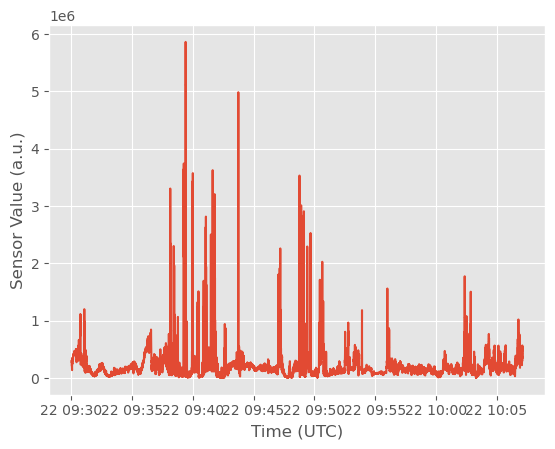

In [3]:
#Visualize the data from a sensor:
SensorData = dataset.streams.TK.AmbientLight.AmbientLight #  Reference one arbitrary sensor data
# Most of the data is in a DataFrame format. Indexed by a column that indicates the time at which the sample was acquired.
print(SensorData.data.head(5))
plt.figure()
plt.plot(SensorData.data)
plt.xlabel("Time (UTC)")
plt.ylabel("Sensor Value (a.u.)")
plt.show()

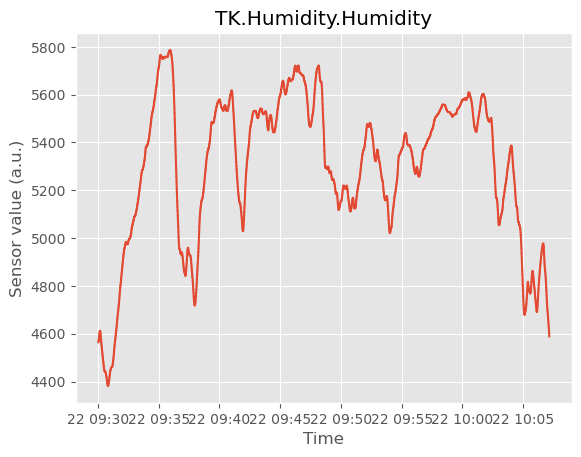

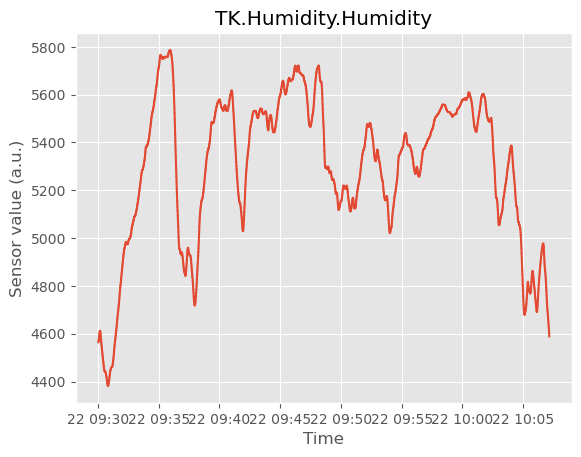

In [4]:
# For simplicity a general method can be used to attempt to plot the data inside a stream:
dataset.streams.TK.Humidity.Humidity.plot()

## Goereferencing

So far, we have sensor data in time, but not in space.

Since have data from the positioning system (UbxStream) and various sensors, we can cross reference the two to get, for each sample, a corresponding spatial-temporal coordinate.

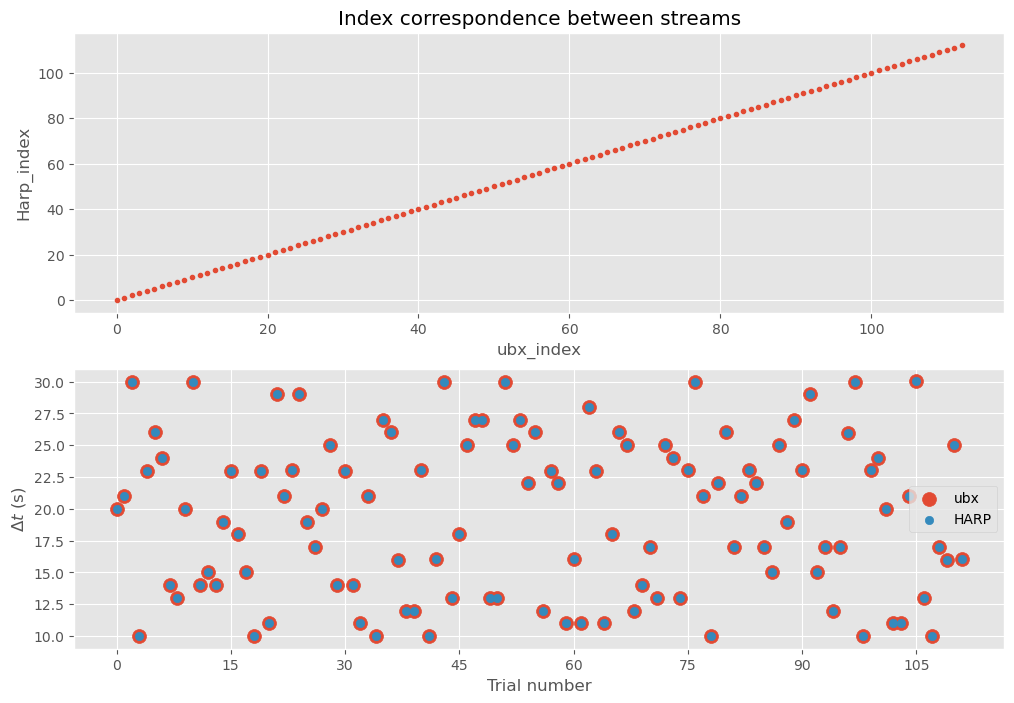

                                Latitude  Longitude  Elevation  \
Seconds                                                          
2022-09-22 09:30:19.708989143  51.539353  -0.147692    92318.8   
2022-09-22 09:30:20.708987713  51.539353  -0.147692    92214.4   
2022-09-22 09:30:21.708986759  51.539354  -0.147690    92052.6   
2022-09-22 09:30:22.708985806  51.539353  -0.147689    91940.9   
2022-09-22 09:30:23.708984375  51.539354  -0.147690    91888.0   
...                                  ...        ...        ...   
2022-09-22 10:07:21.706470966  51.539408  -0.147697    87987.2   
2022-09-22 10:07:22.706470013  51.539409  -0.147696    87725.5   
2022-09-22 10:07:23.706468582  51.539408  -0.147696    87290.7   
2022-09-22 10:07:24.706467628  51.539409  -0.147698    86954.0   
2022-09-22 10:07:25.706466198  51.539411  -0.147698    86367.2   

                                                              geometry  
Seconds                                                             

In [6]:
#  Since the UBX system runs on a distinct hardware "clock" from the rest of
# the acquisition system, we must first correct the temporal drift between them.
drift_correction_model = dataset.calibrate_ubx_to_harp(plot_diagnosis=True) #  We can save the output of the process to inspect later
# if plot_diagnosis is set to True, the output of the automatic alignment algorithm will be plotted for visually inspection and general QC
# In pratice, all points of the second plot should lay on top of each other.


#  After computing the correction model, we can add a sptial UBX event
# (in this case we are going to use the "NAV_HPPOSLLH") as the source of georeference
# and calibrate (calibrate_clock = True) using the previously calculated model
dataset.add_ubx_georeference(event = _UBX_MSGIDS.NAV_HPPOSLLH, calibrate_clock = True)

# Georeference will simply be a DataFrame with spatial information indexed in time:
print(dataset.georeference)


## Visualization:

We are not in a position where we can visualize data in both time and space. The following cells will demo this affordance.

In [ ]:
# The first time you run tilemapbase library, you will need to initiate a cache structure
# Initialize tilemapbase cache (run this only once)
if False:
    import tilemapbase as tmb
    tmb.init(create=True)

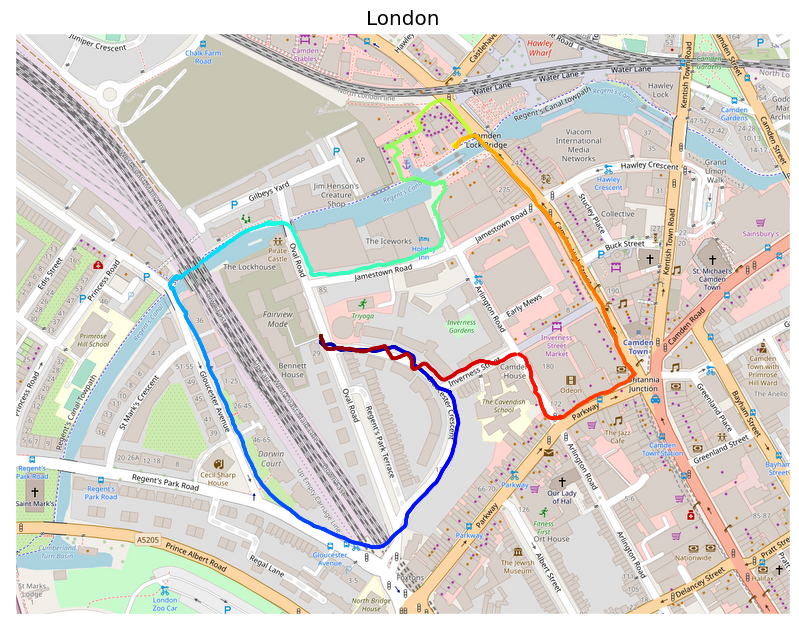

In [7]:
# First we will plot the spatial data colorcoded by time

fig = dataset.showmap(colorscale_override=dataset.georeference.spacetime.index,
                      cmap = "jet",
                      markersize= 5, figsize = (10,10),
                      )
plt.title(dataset.datasetlabel)
plt.show()


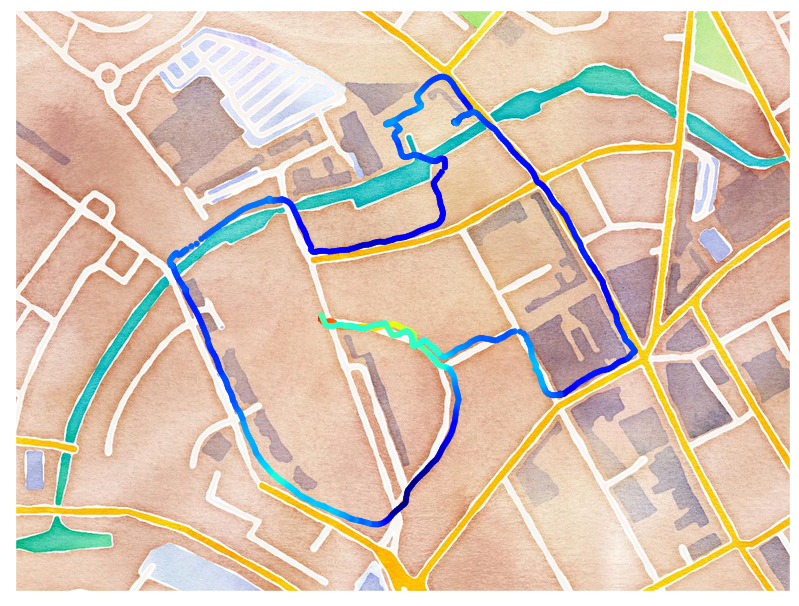

In [10]:
from pluma.preprocessing.resampling import resample_temporospatial
from pluma.plotting.maps import showmap


# resample_temporospatial() resamples data in time and space using a dataset georeference. By default, it resamples the data to 2s bins 

resampled = resample_temporospatial(dataset.streams.TK.AirQuality.Temperature.data,
                                    dataset.georeference,
                                    sampling_dt=datetime.timedelta(seconds = 2))


tiles = tmb.tiles.Stamen_Watercolour # We can change how the map looks by passing an optional "tiles" argument
fig = showmap(resampled,
              figsize=(10,10),
              tiles=tiles)
plt.show()


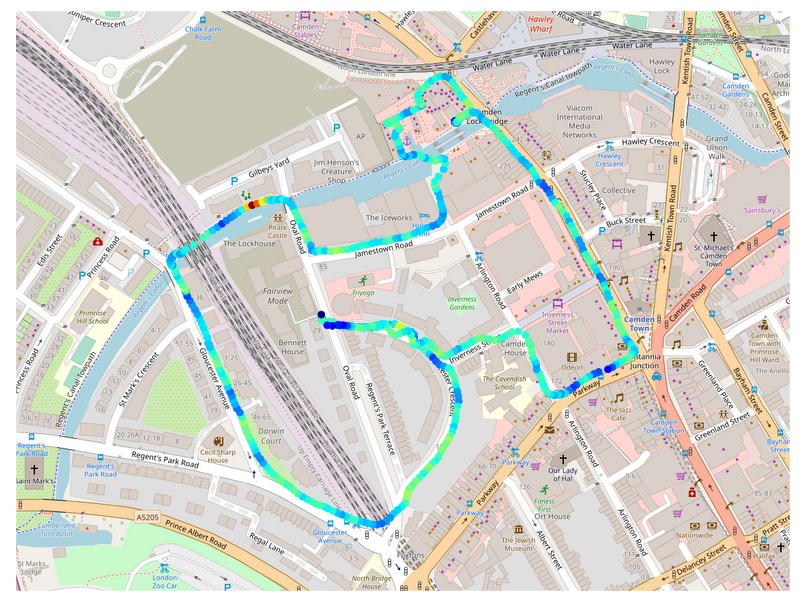

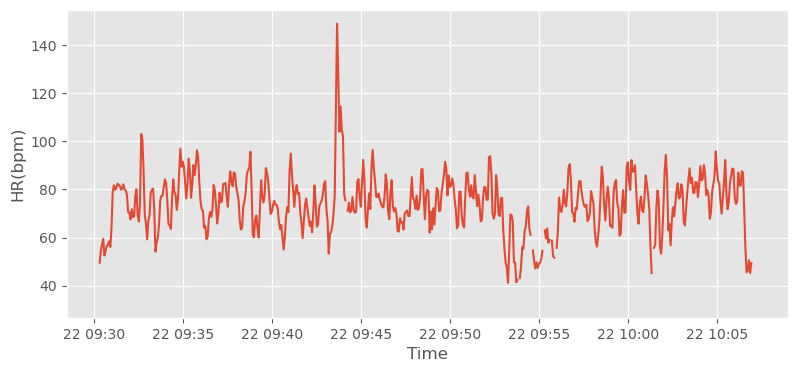

In [11]:
# Sometimes additional preprocessing might be required. As an example, when calculating heart rate from the ECG raw signal.

from pluma.preprocessing.ecg import heartrate_from_ecg

hr,_ = heartrate_from_ecg(dataset.streams.BioData.ECG,
                                         fs = 250, max_heartrate_bpm = 250.0,
                                        peak_height = 800, smooth_win = 10) ## Calculates HR from ecg raw signal

resampled = resample_temporospatial(hr, dataset.georeference,
                                           sampling_dt = datetime.timedelta(seconds = 4)) #Resample
fig = showmap(resampled, figsize=(10,10), cmap = 'jet', markersize = 25 )
plt.show()

## Plot it in time for comparison
plt.figure(figsize= (9.3,4))
plt.plot(resampled.Data)
plt.xlabel('Time')
plt.ylabel('HR(bpm)')
plt.show()

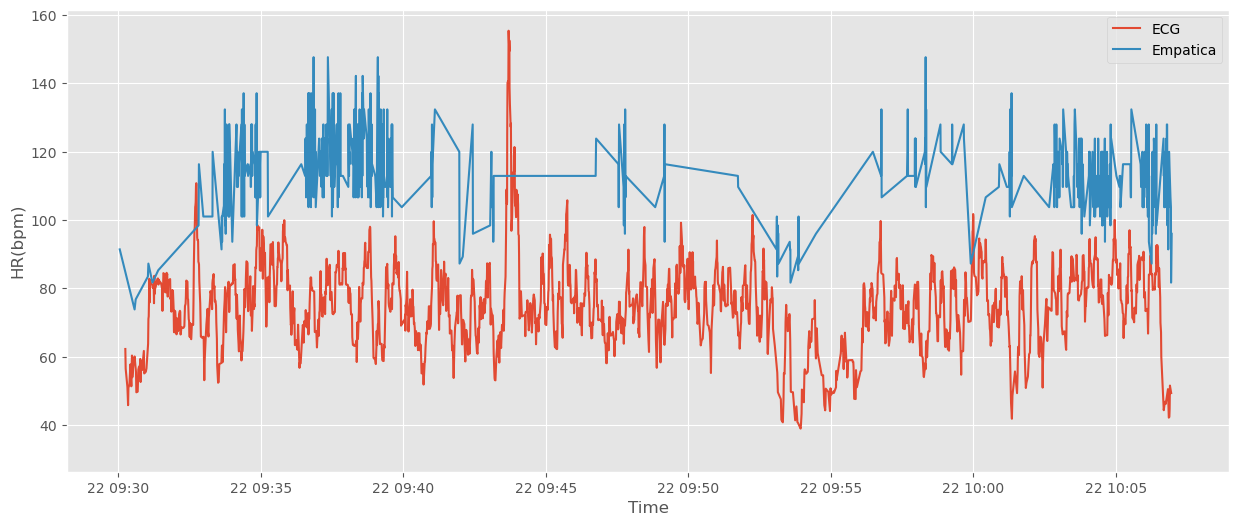

In [12]:
## Comparison of HR given by Empatica and raw ECG signal:
plt.figure(figsize=(15,6))
plt.plot(hr, label = 'ECG')
plt.plot(dataset.streams.Empatica.data.E4_Hr['Value'], label = 'Empatica')
plt.xlabel("Time")
plt.ylabel("HR(bpm)")
plt.legend()
plt.show()